## Загрузим нужные библиотеки

In [469]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import f1_score

%matplotlib inline

In [470]:
df = pd.read_csv("train_dataset_train.csv")

## Рассмотрим датасет поближе

In [471]:
df.head(3)

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08 00:00:00.000,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,...,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18 00:00:00.000,NaN,NaN,NaN,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21 00:00:00.000,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4


In [472]:
df.shape

(13584, 24)

In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                13584 non-null  int64  
 1   Код_группы        13584 non-null  int64  
 2   Год_Поступления   13584 non-null  int64  
 3   Пол               13577 non-null  object 
 4   Основания         13584 non-null  object 
 5   Изучаемый_Язык    12758 non-null  object 
 6   Дата_Рождения     13584 non-null  object 
 7   Уч_Заведение      12351 non-null  object 
 8   Где_Находится_УЗ  12203 non-null  object 
 9   Год_Окончания_УЗ  12284 non-null  float64
 10  Пособие           12576 non-null  float64
 11  Страна_ПП         13237 non-null  object 
 12  Регион_ПП         12966 non-null  object 
 13  Город_ПП          13141 non-null  object 
 14  Общежитие         13498 non-null  float64
 15  Наличие_Матери    13584 non-null  int64  
 16  Наличие_Отца      13584 non-null  float6

Заменим все пропуски в данных

In [474]:
cat_features = df.dtypes[df.dtypes == "object"].index.values
num_features = df.dtypes[df.dtypes != "object"].index.values

In [476]:
for i in cat_features:
    df[i] = df[i].fillna('unknown')
for i in num_features:
    df[i] = df[i].fillna(-9999)

Посмотрим на распределение данных

Text(0.5, 1.0, 'Распределение предсказываемой величены')

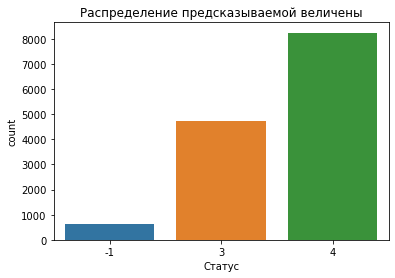

In [477]:
sns.countplot(x = "Статус" , data  = df).set_title('Распределение предсказываемой величены')

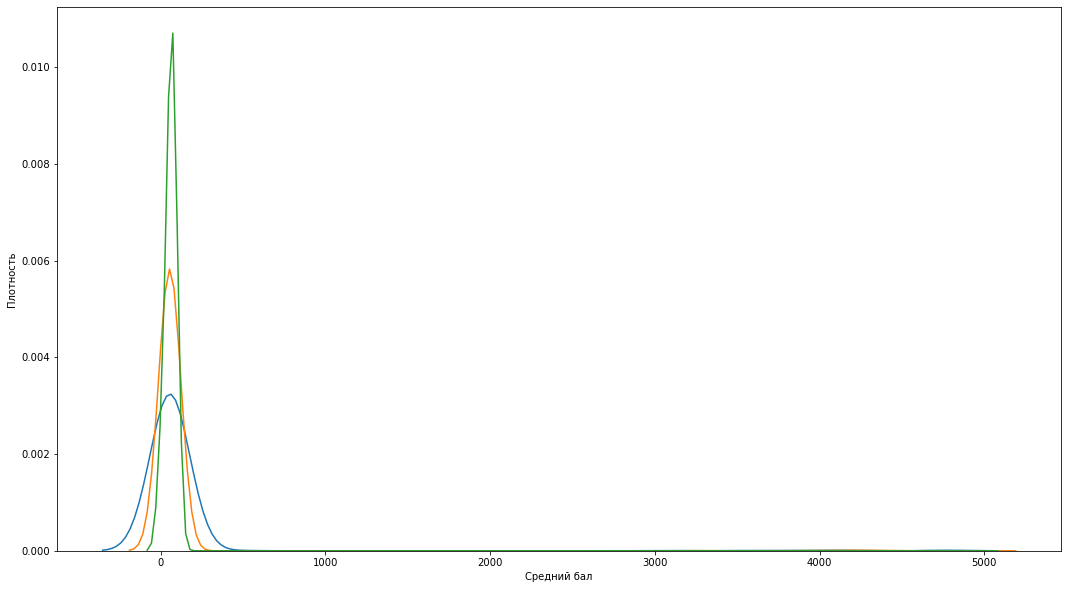

In [478]:
plt.rcParams['figure.figsize'] = 18, 10
fig = sns.kdeplot(df[df['Статус'] == -1]['СрБаллАттестата'], label = '-1')
fig = sns.kdeplot(df[df['Статус'] == 3]['СрБаллАттестата'], label = '3')
fig = sns.kdeplot(df[df['Статус'] == 4]['СрБаллАттестата'], label = '4')
fig.set(xlabel='Средний бал', ylabel='Плотность')  
plt.show()

Text(0.5, 1.0, 'Распределение предсказываемой величены')

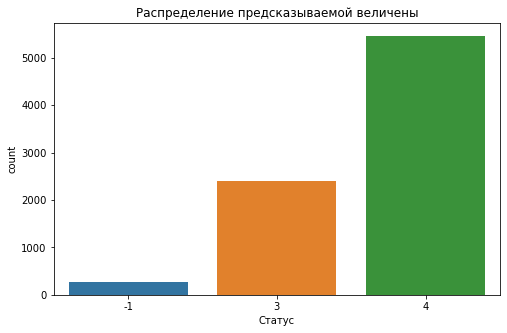

In [479]:
plt.rcParams['figure.figsize'] = 8, 5
df1 = df.query('Пол == "Жен"')
sns.countplot(x = "Статус" , data  = df1).set_title('Распределение предсказываемой величены')

Text(0.5, 1.0, 'Распределение года поступления')

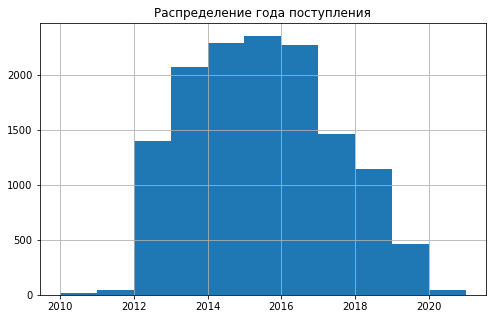

In [480]:
df["Год_Поступления"].hist(bins = 11, range = [2010, 2021]).set_title('Распределение года поступления')

Взглянем на несколько величин сразу

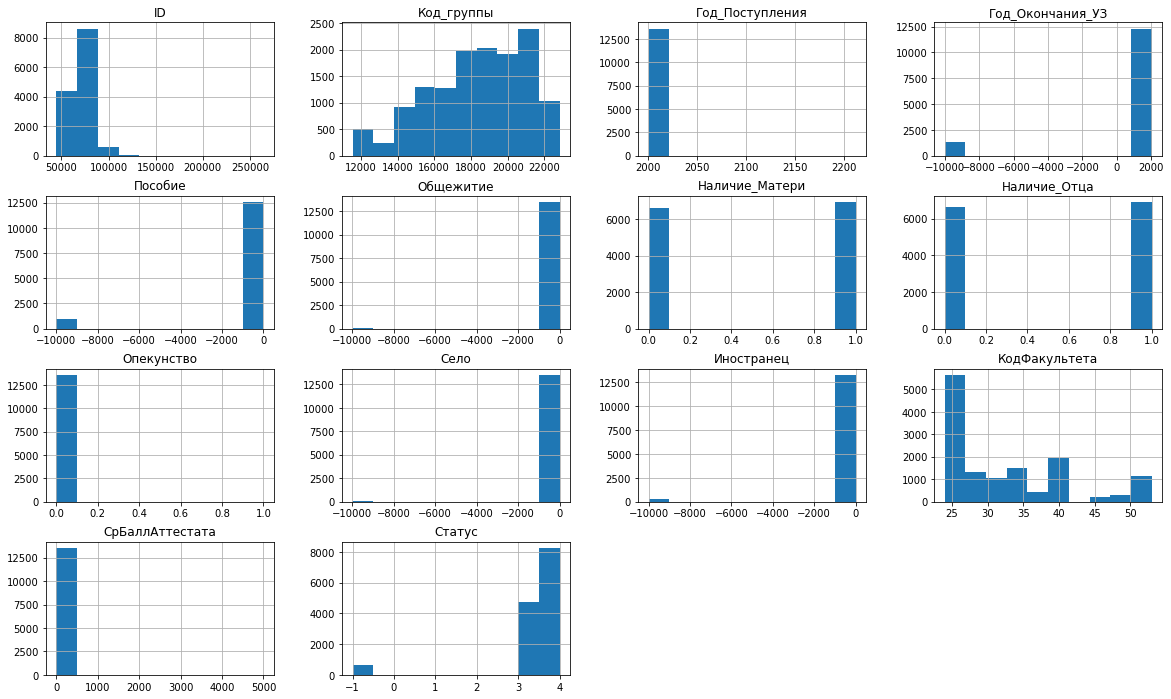

In [481]:
_ = df[df.columns].hist(figsize=(20,12))

Обратим внимание на часть столбцов с постоянными значениями

In [482]:
df.columns.values

array(['ID', 'Код_группы', 'Год_Поступления', 'Пол', 'Основания',
       'Изучаемый_Язык', 'Дата_Рождения', 'Уч_Заведение',
       'Где_Находится_УЗ', 'Год_Окончания_УЗ', 'Пособие', 'Страна_ПП',
       'Регион_ПП', 'Город_ПП', 'Общежитие', 'Наличие_Матери',
       'Наличие_Отца', 'Страна_Родители', 'Опекунство', 'Село',
       'Иностранец', 'КодФакультета', 'СрБаллАттестата', 'Статус'],
      dtype=object)

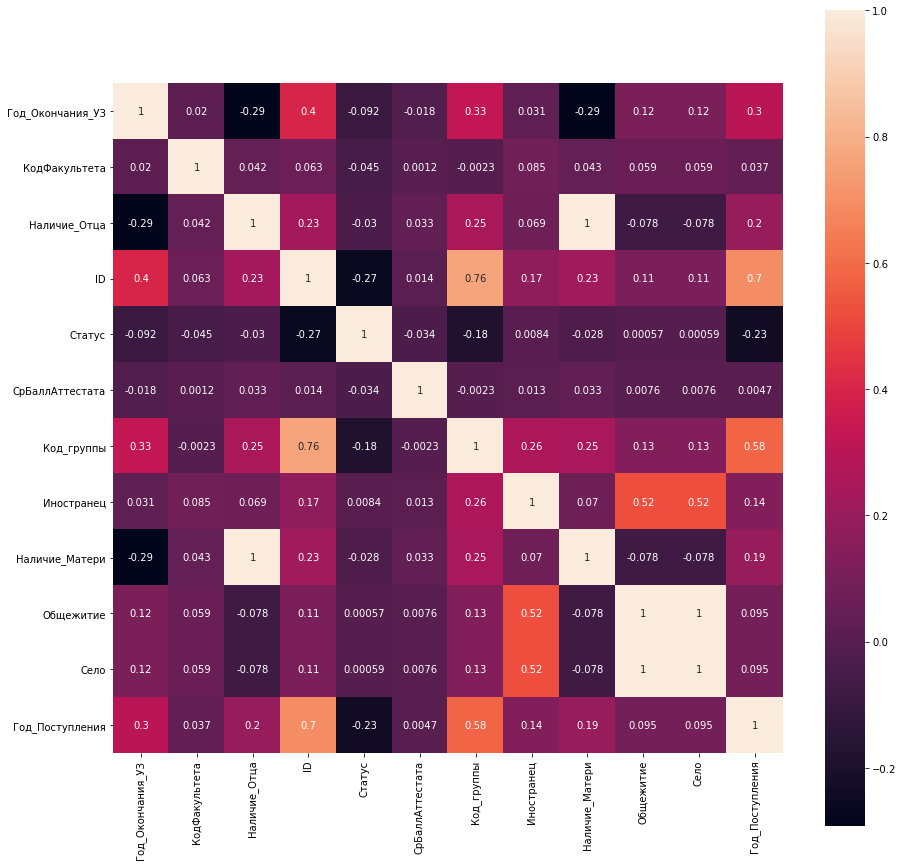

In [483]:
plt.rcParams['figure.figsize']=(15,15)


df_corr = list(set(df.columns.values) - set(['Опекунство','Пособие']))
g = sns.heatmap(df[df_corr].corr(), square = True, annot=True)

Создадим новые признаки:

In [484]:
df['Код_группы1'] = df['Код_группы']//10000
df['Код_группы2'] = df['Код_группы']//1000%10
df['Код_группы3'] = df['Код_группы']//100%10
df['Код_группы4'] = df['Код_группы']//10%10
df['Код_группы5'] = df['Код_группы']%10

In [485]:
df['Дата_Рождения'] = pd.to_datetime(df['Дата_Рождения'])
df['Дата_Рождения'] = df['Дата_Рождения'].dt.year

In [486]:
df['Возрст'] = df['Год_Поступления'] - df['Дата_Рождения']

Сделаем замены в некоторых ключевых признаках

In [488]:
df['Пол'].unique()

array(['Жен', 'Муж', 'unknown', 'муж'], dtype=object)

In [489]:
df['Пол'] = df['Пол'].replace('муж', 'Муж')

In [490]:
df['Город_ПП'] = df['Город_ПП'].replace('г. Барнаул', 'Барнаул г')
df['Город_ПП'] = df['Город_ПП'].replace('Барнаул', 'Барнаул г')
df['Город_ПП'] = df['Город_ПП'].replace('Барнаул  г', 'Барнаул г')
df['Город_ПП'] = df['Город_ПП'].replace('г.Барнаул', 'Барнаул г')
df['Город_ПП'] = df['Город_ПП'].replace('Барнаул г   ', 'Барнаул г')

In [491]:
df['Страна_ПП'] = df['Страна_ПП'].replace('Казахстан Респ', 'Казахстан')
df['Страна_ПП'] = df['Страна_ПП'].replace('Казахстан респ', 'Казахстан')
df['Страна_ПП'] = df['Страна_ПП'].replace('Казахстан ВКО', 'Казахстан')
df['Страна_ПП'] = df['Страна_ПП'].replace('Республика Казахстан', 'Казахстан')
df['Страна_ПП'] = df['Страна_ПП'].replace('Киргизия', 'Кыргызстан')
df['Страна_ПП'] = df['Страна_ПП'].replace('Кыргызия', 'Кыргызстан')
df['Страна_ПП'] = df['Страна_ПП'].replace('Кыргызская Республика', 'Кыргызстан')
df['Страна_ПП'] = df['Страна_ПП'].replace('РОССИЯ', 'Россия')
df['Страна_ПП'] = df['Страна_ПП'].replace('Республика Таджикистан', 'Таджикистан')
df['Страна_ПП'] = df['Страна_ПП'].replace('Таджикистан Респ', 'Таджикистан')

## Выделим выборки

Закодируем признаки техникой OHE

In [493]:
df = pd.get_dummies(df, drop_first=True)

In [494]:
mass_object = df.dtypes[df.dtypes == "object"].index.values

In [495]:
mass_object = np.append(mass_object, "Статус")

In [496]:
X = df.drop(mass_object, axis = 1)
y = df[["Статус"]]

In [497]:
X.shape

(13584, 7773)

In [498]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True, stratify = y)

## Обучение модели

# Catboost

In [499]:
from catboost import CatBoostClassifier 
clf_cb = CatBoostClassifier(iterations=800, verbose = 50)
clf_cb.fit(X_train, y_train)
pred_cb = clf_cb.predict(X_test)
f1_score(y_test, pred_cb, average='macro', zero_division = 0)

Learning rate set to 0.107175
0:	learn: 1.0104639	total: 58.1ms	remaining: 46.4s
50:	learn: 0.3927832	total: 3.17s	remaining: 46.5s
100:	learn: 0.3637136	total: 6.76s	remaining: 46.8s
150:	learn: 0.3563932	total: 10.6s	remaining: 45.6s
200:	learn: 0.3506067	total: 14.3s	remaining: 42.7s
250:	learn: 0.3460552	total: 18s	remaining: 39.5s
300:	learn: 0.3422408	total: 21.2s	remaining: 35.2s
350:	learn: 0.3397227	total: 25.4s	remaining: 32.5s
400:	learn: 0.3367644	total: 28.8s	remaining: 28.7s
450:	learn: 0.3323469	total: 32.1s	remaining: 24.8s
500:	learn: 0.3296004	total: 37.1s	remaining: 22.1s
550:	learn: 0.3262089	total: 40.1s	remaining: 18.1s
600:	learn: 0.3221756	total: 43.2s	remaining: 14.3s
650:	learn: 0.3188596	total: 47s	remaining: 10.8s
700:	learn: 0.3160323	total: 50s	remaining: 7.06s
750:	learn: 0.3140202	total: 52.9s	remaining: 3.45s
799:	learn: 0.3105891	total: 56.2s	remaining: 0us


0.7410207275367351

In [500]:
for key,value in clf_cb.get_all_params().items():
    print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, MultiClass
iterations, 800
sampling_frequency, PerTree
leaf_estimation_method, Newton
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
bayesian_matrix_reg, 0.10000000149011612
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
rsm, 1
boost_from_average, False
model_size_reg, 0.5
pool_metainfo_options, {'tags': {}}
use_best_model, False
class_names, [-1, 3, 4]
random_seed, 0
depth, 6
posterior_sampling, False
border_count, 254
bagging_temperature, 1
classes_count, 0
auto_class_weights, None
sparse_features_conflict_fraction, 0
leaf_estimation_backtracking, AnyImprovement
best_model_min_trees, 1
model_shrink_rate, 0
min_data_in_leaf, 1
loss_function, MultiClass
learning_rate, 0.10717500001192092
score_function, Cosine
task_type, CPU
leaf_estimation_iterations, 1
bootstrap_type, Bayesian
max_leaves, 64


Посмотрим на первые 50 значимых признаков, на основании этих  данных был проведен EDA

In [501]:
clf_cb.get_feature_importance(prettified=True)[0:50]

,Feature Id,Importances
0,Код_группы,32.079910
1,Основания_ОО,10.029729
2,ID,9.705121
3,Год_Поступления,8.443172
4,Основания_СН,7.878592
5,СрБаллАттестата,5.730299
6,Код_группы2,3.894811
7,Дата_Рождения,3.038830
8,Основания_ДН,2.877238
9,КодФакультета,2.875479


Отберем 25 наиболее значимых признаков и посчитаем метрику

In [502]:
fich = list(clf_cb.get_feature_importance(prettified=True)[0:25]['Feature Id'])

In [503]:
fich

['Код_группы',
 'Основания_ОО',
 'ID',
 'Год_Поступления',
 'Основания_СН',
 'СрБаллАттестата',
 'Код_группы2',
 'Дата_Рождения',
 'Основания_ДН',
 'КодФакультета',
 'Код_группы3',
 'Пособие',
 'Возрст',
 'Год_Окончания_УЗ',
 'Код_группы4',
 'Пол_Жен',
 'Наличие_Матери',
 'Пол_Муж',
 'Код_группы5',
 'Где_Находится_УЗ_Алтайский край, Барнаул г',
 'Наличие_Отца',
 'Иностранец',
 'Город_ПП_Барнаул г',
 'Общежитие',
 'Изучаемый_Язык_Немецкий язык']

In [504]:
X_train = X_train[fich]

In [505]:
from catboost import CatBoostClassifier 
clf_cb = CatBoostClassifier(iterations=800, verbose = 50)
clf_cb.fit(X_train, y_train)
pred_cb = clf_cb.predict(X_test)
f1_score(y_test, pred_cb, average='macro', zero_division = 0)

Learning rate set to 0.107175
0:	learn: 1.0110086	total: 17.2ms	remaining: 13.8s
50:	learn: 0.3841127	total: 634ms	remaining: 9.31s
100:	learn: 0.3309481	total: 1.2s	remaining: 8.32s
150:	learn: 0.3011106	total: 1.97s	remaining: 8.49s
200:	learn: 0.2802850	total: 2.53s	remaining: 7.54s
250:	learn: 0.2639121	total: 3.1s	remaining: 6.77s
300:	learn: 0.2498513	total: 3.75s	remaining: 6.22s
350:	learn: 0.2376524	total: 4.3s	remaining: 5.51s
400:	learn: 0.2272384	total: 4.85s	remaining: 4.83s
450:	learn: 0.2175031	total: 5.41s	remaining: 4.19s
500:	learn: 0.2073402	total: 5.96s	remaining: 3.56s
550:	learn: 0.1980898	total: 6.53s	remaining: 2.95s
600:	learn: 0.1892378	total: 7.09s	remaining: 2.35s
650:	learn: 0.1820791	total: 7.64s	remaining: 1.75s
700:	learn: 0.1743870	total: 8.2s	remaining: 1.16s
750:	learn: 0.1679342	total: 8.77s	remaining: 572ms
799:	learn: 0.1619351	total: 9.31s	remaining: 0us


0.7725438604812292

Обучим модель на всей тестовой выборке

In [508]:
X = X[fich]

In [509]:
clf_cb = CatBoostClassifier(iterations=800, verbose = 50)
clf_cb.fit(X, y)


Learning rate set to 0.109143
0:	learn: 1.0046732	total: 33.6ms	remaining: 26.8s
50:	learn: 0.3752965	total: 774ms	remaining: 11.4s
100:	learn: 0.3275935	total: 1.5s	remaining: 10.4s
150:	learn: 0.2982976	total: 2.18s	remaining: 9.36s
200:	learn: 0.2822806	total: 2.8s	remaining: 8.33s
250:	learn: 0.2667970	total: 3.44s	remaining: 7.52s
300:	learn: 0.2545109	total: 4.06s	remaining: 6.72s
350:	learn: 0.2432405	total: 4.69s	remaining: 6s
400:	learn: 0.2331976	total: 5.32s	remaining: 5.3s
450:	learn: 0.2244927	total: 5.95s	remaining: 4.61s
500:	learn: 0.2168866	total: 6.62s	remaining: 3.95s
550:	learn: 0.2085422	total: 7.27s	remaining: 3.29s
600:	learn: 0.2013043	total: 7.9s	remaining: 2.62s
650:	learn: 0.1945585	total: 8.54s	remaining: 1.96s
700:	learn: 0.1889108	total: 9.17s	remaining: 1.29s
750:	learn: 0.1828347	total: 9.82s	remaining: 641ms
799:	learn: 0.1781644	total: 10.4s	remaining: 0us


# Cоздание файла с ответом

In [510]:
df_test = pd.read_csv("test_dataset_test.csv")
df_submission = pd.read_csv("sample_submission.csv")

Провем те же манипуляции с данными что и на обучении

In [511]:
cat_features = df_test.dtypes[df_test.dtypes == "object"].index.values
num_features = df_test.dtypes[df_test.dtypes != "object"].index.values

In [512]:
for i in cat_features:
    df_test[i] = df_test[i].fillna('unknown')
for i in num_features:
    df_test[i] = df_test[i].fillna(-9999)

In [513]:
df_test['Код_группы1'] = df_test['Код_группы']//10000
df_test['Код_группы2'] = df_test['Код_группы']//1000%10
df_test['Код_группы3'] = df_test['Код_группы']//100%10
df_test['Код_группы4'] = df_test['Код_группы']//10%10
df_test['Код_группы5'] = df_test['Код_группы']%10

In [514]:
df_test['Пол'].unique()

array(['Жен', 'Муж', 'unknown', 'жен'], dtype=object)

In [515]:
df_test['Пол'] = df_test['Пол'].replace('жен', 'Жен')

In [516]:
df_test['Город_ПП'] = df_test['Город_ПП'].replace('г. Барнаул', 'Барнаул г')
df_test['Город_ПП'] = df_test['Город_ПП'].replace('Барнаул', 'Барнаул г')
df_test['Город_ПП'] = df_test['Город_ПП'].replace('Барнаул  г', 'Барнаул г')
df_test['Город_ПП'] = df_test['Город_ПП'].replace('г.Барнаул', 'Барнаул г')
df_test['Город_ПП'] = df_test['Город_ПП'].replace('Барнаул г   ', 'Барнаул г')

In [517]:
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('Казахстан Респ', 'Казахстан')
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('Казахстан респ', 'Казахстан')
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('Казахстан ВКО', 'Казахстан')
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('Республика Казахстан', 'Казахстан')
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('КАЗАХСТАН', 'Казахстан')
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('Киргизия', 'Кыргызстан')
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('Кыргызия', 'Кыргызстан')
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('Кыргызская Республика', 'Кыргызстан')
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('РОССИЯ', 'Россия')
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('Республика Таджикистан', 'Таджикистан')
df_test['Страна_ПП'] = df_test['Страна_ПП'].replace('Таджикистан Респ', 'Таджикистан')


In [519]:
df_test['Дата_Рождения'] = pd.to_datetime(df_test['Дата_Рождения'])
df_test['Дата_Рождения'] = df_test['Дата_Рождения'].dt.year

In [520]:
df_test['Возрст'] = df_test['Год_Поступления'] - df_test['Дата_Рождения']

In [521]:
df_test = pd.get_dummies(df_test, drop_first=True)

In [522]:
df_test = df_test[fich]

In [523]:
df_test_pred = clf_cb.predict(df_test)

In [524]:
df_submission["Статус"] = df_test_pred
df_submission.head(4)

,ID,Статус
0,64996,4
1,71837,4
2,86587,3
3,73673,-1


In [525]:
df_submission.set_index('ID', inplace = True)

In [466]:
df_submission.to_csv("sample_submission1.csv")